In [1]:
import odc.stac
from pystac_client import Client
import matplotlib.pyplot as plt
import pandas as pd

# Open catalog
catalog = Client.open(
    "https://storage.googleapis.com/gca-data-public/gca/gca-stac-12/catalog.json"
)
list(catalog.get_children())

c:\Users\fuentesm\AppData\Local\miniforge3\envs\coclico\Lib\site-packages\pystac_client\client.py:191: NoConformsTo: Server does not advertise any conformance classes.
  warnings.warn(NoConformsTo())


[<CollectionClient id=shore_mon_fut>,
 <CollectionClient id=sed_class>,
 <CollectionClient id=shore_mon>,
 <CollectionClient id=world_pop>,
 <CollectionClient id=world_gdp>,
 <CollectionClient id=shore_mon_hr>,
 <CollectionClient id=shore_mon_drivers>,
 <CollectionClient id=esl_gwl>,
 <CollectionClient id=sub_threat>,
 <CollectionClient id=SPMN>,
 <CollectionClient id=salinity_increase>,
 <CollectionClient id=salinity>]

In [2]:
# Choose a collection
collection_id = "salinity_increase"  # example
collection = catalog.get_collection(collection_id)

# Get items from the collection
items = list(collection.get_items())
print(f"Found {len(items)} items")

# Explore first item
item = items[0]
print("Item ID:", item.id)
print("Datetime:", item.datetime)
print("Assets:", item.assets.keys(), "\n")

# Explore a specific item
item_id = "cc45y/p50_2030.tif" #TODO: To work on this id
item = collection.get_item(item_id)
print("Item ID:", item.id)
print("Datetime:", item.datetime)
print("Assets:", item.assets.keys())


c:\Users\fuentesm\AppData\Local\miniforge3\envs\coclico\Lib\site-packages\pystac_client\client.py:410: FallbackToPystac: Falling back to pystac. This might be slow.
  self._warn_about_fallback("COLLECTIONS", "FEATURES")
c:\Users\fuentesm\AppData\Local\miniforge3\envs\coclico\Lib\site-packages\pystac_client\collection_client.py:149: FallbackToPystac: Falling back to pystac. This might be slow.
  root._warn_about_fallback("ITEM_SEARCH")


Found 15 items
Item ID: cc45y/p50_2030.tif
Datetime: 2022-02-22 00:00:00+00:00
Assets: dict_keys(['data', 'visual']) 

Item ID: cc45y/p50_2030.tif
Datetime: 2022-02-22 00:00:00+00:00
Assets: dict_keys(['data', 'visual'])


c:\Users\fuentesm\AppData\Local\miniforge3\envs\coclico\Lib\site-packages\pystac_client\collection_client.py:197: FallbackToPystac: Falling back to pystac. This might be slow.
  root._warn_about_fallback("FEATURES", "ITEM_SEARCH")


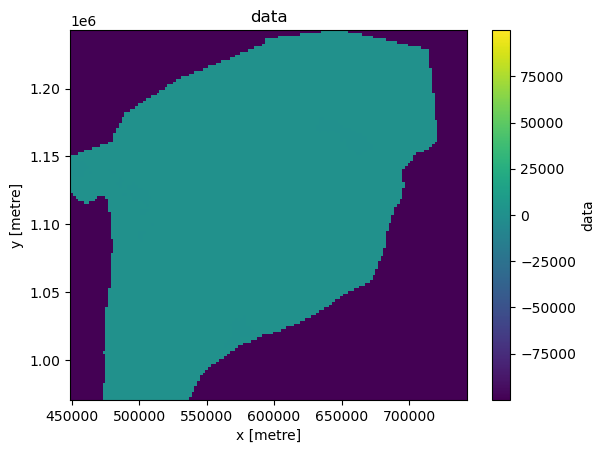

In [3]:
# Load as xarray dataset
ds = odc.stac.load([item])

# Plot the first band
ds_band = list(ds.data_vars)[0]  
ds[ds_band].plot(cmap="viridis")  
plt.title(ds_band)
plt.show()


In [4]:
# Get the asset with key 'visual'
visual_asset = item.assets.get("visual")

if visual_asset is not None:
    print("Found asset 'visual':")
    print("HREF:", visual_asset.href)
    print("Media Type:", visual_asset.media_type)
    print("Title:", visual_asset.title)
    print("Description:", visual_asset.description)
else:
    print("Asset with key 'visual' not found")

Found asset 'visual':
HREF: https://international-delta-platform.avi.directory.intra/geoserver/wms/salinity_increase
Media Type: application/png
Title: cc45y_p50_2030
Description: OGS WMS url


In [5]:
from ipyleaflet import Map, WMSLayer, basemaps

# Define the WMS layer
wms = WMSLayer(
    url=visual_asset.href,
    layers=visual_asset.title,
    format='image/png',
    transparent=True,
)

# Create the map centered on Vietnam
m = Map(
    basemap=basemaps.CartoDB.Positron,
    center=(10.0, 107.0),  # Latitude, Longitude
    zoom=7                 # Zoom level (4 is too far, 6–7 is better for Vietnam)
)

# Add the WMS layer
m.add(wms)

# Display the map
m


Map(center=[10.0, 107.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

In [6]:
import folium

# Create map centered on Vietnam
m = folium.Map(location=[10.0, 107.0], zoom_start=7)

# Add WMS layer
folium.raster_layers.WmsTileLayer(
    url=visual_asset.href,
    layers=visual_asset.title,  # layer name
    name=visual_asset.title,    # layer display name
    fmt="image/png",
    transparent=True,
    attr="GeoServer WMS"        # Use 'attr' instead of 'attribution'
).add_to(m)

# Display map
m


In [7]:
import leafmap.foliumap as leafmap

# Create map centered on Vietnam
m = leafmap.Map(center=[10.0, 107.0], zoom=7)

# Add WMS layer (do NOT pass fmt)
m.add_wms_layer(
    url=visual_asset.href,
    layers=visual_asset.title,
    name="WMS Layer",
    format="image/png",      # use 'format' instead of 'fmt'
    transparent=True,
    attribution="GeoServer WMS"
)

m


In [11]:
import ipywidgets as widgets
from ipyleaflet import Map, WMSLayer

# WMS layer options
layer_select = widgets.Dropdown(
    options=[visual_asset.title, 'another_layer'],
    description='Layer:',
)

m = Map(center=(10.0, 107.0), zoom=7)
wms = WMSLayer(url=visual_asset.href, layers=visual_asset.title, format='image/png', transparent=True)
m.add(wms)

def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        wms.layers = change['new']

layer_select.observe(on_change)
display(layer_select, m)


Dropdown(description='Layer:', options=('cc45y_p50_2030', 'another_layer'), value='cc45y_p50_2030')

Map(center=[10.0, 107.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

In [9]:
import leafmap.foliumap as leafmap

# Create a Leafmap map centered on Vietnam
m = leafmap.Map(center=[10.0, 107.0], zoom=7, style="streets")

# Your WMS details
url = visual_asset.href           # e.g. "https://your-geoserver/wms"
layers = visual_asset.title       # e.g. "cc45y_2030"

# Important: Leafmap expects "format=", NOT "fmt="
m.add_wms_layer(
    url=url,
    layers=layers,
    format="image/png",
    transparent=True,
)

m
